# Regresja liniowa
Dane pochodzą z konkursu na kaggle dotyczącym predykcji cen domów: https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data
Zajęliśmy się rowiązaniem zaproponowanym przez jednego z użytkowników: https://www.kaggle.com/mosa94/linear-regression-implementations

In [1]:
import numpy as np #import biblioteki do obliczeń na macierzach (i tensorach)
import pandas as pd #import biblioteki do przetwarzania ramek z danymi

### Spójrzmy jak wyglądają dane (dla przykładu 5 najdrożych domów)

In [2]:
pd.read_csv('train.csv').sort_values(by='SalePrice',ascending=False).reset_index(drop=True).head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,692,60,RL,104.0,21535,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2007,WD,Normal,755000
1,1183,60,RL,160.0,15623,Pave,NaN,IR1,Lvl,AllPub,...,555,Ex,MnPrv,NaN,0,7,2007,WD,Abnorml,745000
2,1170,60,RL,118.0,35760,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,7,2006,WD,Normal,625000
3,899,20,RL,100.0,12919,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,3,2010,New,Partial,611657
4,804,60,RL,107.0,13891,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2009,New,Partial,582933


### Funkcja do zmiany ramki danych na zbiory treningowe i do cross-walidacji

In [3]:
def data_processing(data,names_of_x,name_of_y,cv=0.8,seed=123):
    data = data.sample(data.shape[0],random_state=seed) #losowa zmiana kolejności wierszy
    dataX = np.array(data.loc[:,names_of_x]) #wybranie odpowiednich kolumn
    dataX = np.c_[np.ones(dataX.shape[0]),dataX] #dodanie kolumny jedynek
    #tylko, gdy names_of_x ma 1 element - też dodanie jedynek
    #dataX = np.stack((np.ones(np.shape(dataX)[0]),dataX),axis=1)
    dataY = np.array(data.loc[:,name_of_y]) #wektor wartości
    
    trainX = dataX[0:int(data.shape[0]*cv),:] #dane treningowe X
    cvX = dataX[int(data.shape[0]*cv):data.shape[0],:] #dane do cross-walidacji X
    trainY = dataY[0:int(data.shape[0]*cv)] #dane treningowe Y
    cvY = dataY[int(data.shape[0]*cv):data.shape[0]] #dane do cross-walidacji Y
    return(trainX, trainY, cvX, cvY)

train = pd.read_csv('train.csv')
(trainX, trainY, cvX, cvY) = data_processing(train,('LotArea'),'SalePrice')

### Obliczmy model regresji liniowej i porównajmy go z losowym modelem w celu sprawdzenia, czy regresja logistyczna nie zwraca losowych wartości.

In [21]:
model = np.linalg.inv(trainX.transpose() @ trainX) @ trainX.transpose() @ trainY
random = np.random.rand(1,2)*1000
def square_mean(X, Y, model):
    return np.mean((X @ model.transpose() - Y) **2) ** (1/2)
square_mean(trainX,trainY,model),square_mean(trainX,trainY,random)

(76896.19119492351, 11786952.080151206)

Widzimy, że błąd losowego modelu jest "zawsze" gorszy niż obliczonego, więc można sądzić, że dobrze zaimplementowaliśmy regresję logistyczną. Jednak model powinno się testować na zbiorze do cross-walidacji, więc teraz to sprawdźmy.

In [22]:
square_mean(cvX,cvY,model),square_mean(cvX,cvY,random)

(75627.79987938722, 10429811.704608858)

Model radzi sobie lepiej na zbiorze do cross-walidacji niż na zbiorze treningowym co jest bardzo dziwne, ale akceptowalne ze względu na zbliżony błąd
Zwizualizujmy teraz dane i model w postaci dopasowanej linii

In [23]:
import matplotlib.pyplot as plt #biblioteka do rysowania wykresów

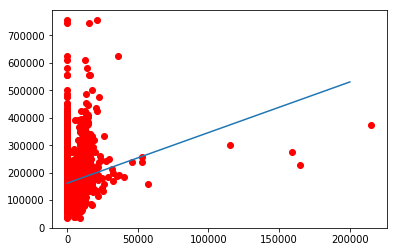

In [24]:
plt.plot(trainX,trainY,'ro') #punkty oznaczające domy
x = np.array([0,200000]) #x i y potrzebne do zrobienia linii
y = model[1]*x + model[0]
plt.plot(x,y) #dodanie linii

Na wykresie można zobaczyć, że mamy kilka 'outlierów', do których model stara się dopasować linię - spróbujmy je usunąć

Model z outlierami na zbiorze treningowym 78168.23228608428 oraz model bez outlierow 74606.81949514126
Model z outlierami na zbiorze cross-walidacji 65293.46534522148 oraz model bez outlierow 64499.54476587264


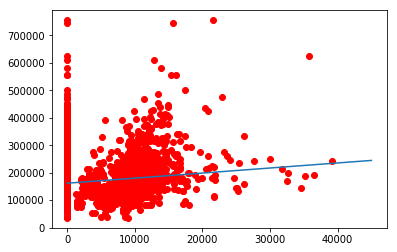

In [25]:
train = pd.read_csv('train.csv')
train = train.loc[train.LotArea<45000,:]
(trainX, trainY, cvX, cvY) = data_processing(train,('LotArea'),'SalePrice')
model_new = np.linalg.inv(trainX.transpose() @ trainX) @ trainX.transpose() @ trainY
print('Model z outlierami na zbiorze treningowym {0} oraz model bez outlierow {1}'.format(square_mean(trainX,trainY,model),square_mean(trainX,trainY,model_new)))
print('Model z outlierami na zbiorze cross-walidacji {0} oraz model bez outlierow {1}'.format(square_mean(cvX,cvY,model),square_mean(cvX,cvY,model_new)))
plt.plot(trainX,trainY,'ro') #punkty oznaczające domy
x = np.array([0,45000]) #x i y potrzebne do zrobienia linii
y = model[1]*x + model[0]
plt.plot(x,y) #dodanie linii

Jak widać usunięcie części danych pozwoli lepiej dopasować prostą. Niepokojące są również punkty, które na osi X mają wartość 0. Mogą to być na przykład wartości NA - ich też powinno się pozbyć.

## TO DO
Można zrobić jeszcze wiele rzeczy na tych danych, np:
- Sprawdź jak zachowuje się model po usunięciu punktów o współrzędnej X równej 0
- Dodaj więcej zmiennych i zwizualizuj dane używając zmniejszania wymiarów danych (np. PCA)
- Stwórz klasę linear_regression na wzór modeli z scikitlearn. To znaczy - zaimplementuj metody fit i predict, a w polach klasy przechowuj parametry regresji.
- Korzystając z biblioteki tensorflow/keras/scikitlearn wytrenuj sieć neuronową lub inny model uczenia maszynowego, który będzie przewidywać SalePrice.